In [3]:
# Step 1: Import Libraries and Set Device
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Step 1 executed: Libraries imported and device set to", device)


Step 1 executed: Libraries imported and device set to cuda


In [4]:
# Step 2: Define Transformations
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

print("Step 2 executed: Transformations defined")


Step 2 executed: Transformations defined


In [5]:
# Step 3: Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.classes = sorted([d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))])
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.samples.append((os.path.join(class_dir, file_name), label))
                    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image_path, label = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

print("Step 3 executed: Custom dataset class defined")


Step 3 executed: Custom dataset class defined


In [6]:
# Step 4: Create Datasets and DataLoaders
data_dir = r"/kaggle/input/the-wildfire-dataset/the_wildfire_dataset_2n_version"  # Update as needed

train_dataset_custom = CustomImageDataset(os.path.join(data_dir, "train"), transform=train_transforms)
val_dataset_custom   = CustomImageDataset(os.path.join(data_dir, "val"), transform=val_test_transforms)
test_dataset_custom  = CustomImageDataset(os.path.join(data_dir, "test"), transform=val_test_transforms)

batch_size = 32
train_loader_custom = DataLoader(train_dataset_custom, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader_custom   = DataLoader(val_dataset_custom, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader_custom  = DataLoader(test_dataset_custom, batch_size=batch_size, shuffle=False, num_workers=4)

dataloaders = {"train": train_loader_custom, "val": val_loader_custom}
print("Step 4 executed: Datasets and DataLoaders created")
print("Classes:", train_dataset_custom.classes)


Step 4 executed: Datasets and DataLoaders created
Classes: ['fire', 'nofire']


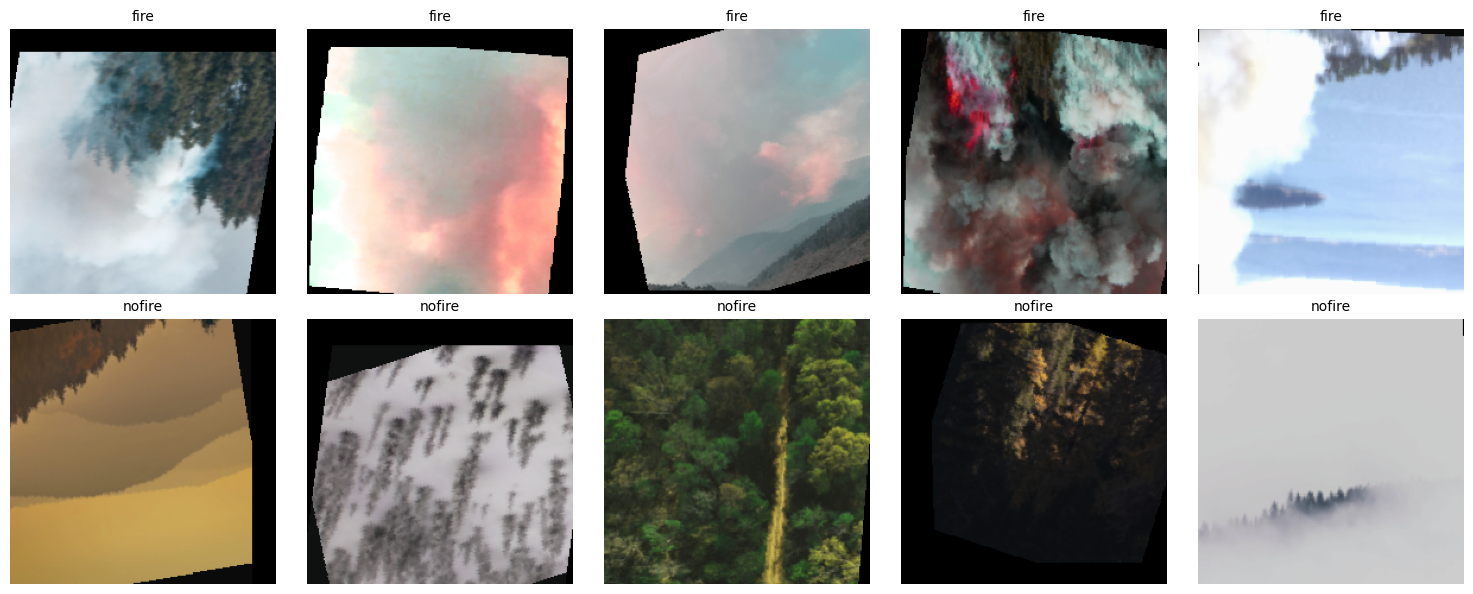

Step 5 executed: Sample images visualized


In [7]:
# Step 5: Visualize Sample Images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')
    if title:
        plt.title(title, fontsize=10)

def visualize_samples(dataset, classes, samples_per_class=5):
    fig = plt.figure(figsize=(samples_per_class*3, len(classes)*3))
    for cls_idx, cls in enumerate(classes):
        count = 0
        for img, label in dataset:
            if label == cls_idx:
                count += 1
                ax = fig.add_subplot(len(classes), samples_per_class, cls_idx * samples_per_class + count)
                imshow(img, title=cls)
                if count == samples_per_class:
                    break
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset_custom, train_dataset_custom.classes, samples_per_class=5)
print("Step 5 executed: Sample images visualized")


In [8]:
# Step 6: Define Model Functions
from torchvision.models import resnet18, resnet50, vgg16, ResNet18_Weights, ResNet50_Weights, VGG16_Weights

def get_pretrained_resnet18(num_classes=2):
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def get_pretrained_resnet50(num_classes=2):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)

def get_pretrained_vgg16(num_classes=2):
    model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
    in_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(in_features, num_classes)
    return model.to(device)

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)
        )
        self.flattened_size = 128 * 28 * 28
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def get_custom_cnn(num_classes=2):
    model = CustomCNN(num_classes=num_classes)
    return model.to(device)

print("Step 6 executed: Model functions defined")
print("ResNet18 Architecture:")
print(get_pretrained_resnet18())
print("\nResNet50 Architecture:")
print(get_pretrained_resnet50())
print("\nVGG16 Architecture:")
print(get_pretrained_vgg16())
print("\nCustom CNN Architecture:")
print(get_custom_cnn())


Step 6 executed: Model functions defined
ResNet18 Architecture:


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 143MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 210MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
# Step 7: Training Function with Early Stopping
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=40, patience=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    no_improve = 0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-"*10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase=='train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
            epoch_loss = running_loss/len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double()/len(dataloaders[phase].dataset)
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")
            if phase=='train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
                scheduler.step()
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    no_improve = 0
                else:
                    no_improve += 1
        print()
        if no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (no improvement for {patience} epochs).")
            break
    time_elapsed = time.time()-since
    print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print("Best Val Acc: {:.4f}".format(best_acc))
    model.load_state_dict(best_model_wts)
    history = {"train_losses": train_losses, "val_losses": val_losses,
               "train_accuracies": train_accuracies, "val_accuracies": val_accuracies}
    return model, history

print("Step 7 executed: Training function defined")


Step 7 executed: Training function defined


In [10]:
# Step 8: Train Models
num_epochs = 40
patience = 5

criterion = nn.CrossEntropyLoss()
print("Criterion defined: CrossEntropyLoss")


# Train ResNet18
model_resnet18 = get_pretrained_resnet18()
optimizer_r18 = optim.Adam(model_resnet18.parameters(), lr=0.001)
scheduler_r18 = optim.lr_scheduler.StepLR(optimizer_r18, step_size=7, gamma=0.1)
print("\nTraining ResNet18:")
model_resnet18, history_r18 = train_model(model_resnet18, dataloaders, criterion, optimizer_r18, scheduler_r18, num_epochs=num_epochs, patience=patience)

# Train ResNet50
model_resnet50 = get_pretrained_resnet50()
optimizer_r50 = optim.Adam(model_resnet50.parameters(), lr=0.001)
scheduler_r50 = optim.lr_scheduler.StepLR(optimizer_r50, step_size=7, gamma=0.1)
print("\nTraining ResNet50:")
model_resnet50, history_r50 = train_model(model_resnet50, dataloaders, criterion, optimizer_r50, scheduler_r50, num_epochs=num_epochs, patience=patience)

# Train VGG16
model_vgg16 = get_pretrained_vgg16()
optimizer_vgg = optim.Adam(model_vgg16.parameters(), lr=0.001)
scheduler_vgg = optim.lr_scheduler.StepLR(optimizer_vgg, step_size=7, gamma=0.1)
print("\nTraining VGG16:")
model_vgg16, history_vgg = train_model(model_vgg16, dataloaders, criterion, optimizer_vgg, scheduler_vgg, num_epochs=num_epochs, patience=patience)

# Train CustomCNN
model_custom = get_custom_cnn()
optimizer_custom = optim.Adam(model_custom.parameters(), lr=0.001)
scheduler_custom = optim.lr_scheduler.StepLR(optimizer_custom, step_size=7, gamma=0.1)
print("\nTraining CustomCNN:")
model_custom, history_custom = train_model(model_custom, dataloaders, criterion, optimizer_custom, scheduler_custom, num_epochs=num_epochs, patience=patience)

print("Step 8 executed: Models trained")


Criterion defined: CrossEntropyLoss

Training ResNet18:
Epoch 1/40
----------
Train Loss: 0.6418 Acc: 0.6852
Val Loss: 0.5999 Acc: 0.6642

Epoch 2/40
----------
Train Loss: 0.5410 Acc: 0.7117
Val Loss: 0.6051 Acc: 0.6965

Epoch 3/40
----------
Train Loss: 0.5168 Acc: 0.7525
Val Loss: 0.5081 Acc: 0.7662

Epoch 4/40
----------
Train Loss: 0.4926 Acc: 0.7631
Val Loss: 0.4479 Acc: 0.8109

Epoch 5/40
----------
Train Loss: 0.4818 Acc: 0.7674
Val Loss: 0.8633 Acc: 0.6592

Epoch 6/40
----------
Train Loss: 0.4611 Acc: 0.7917
Val Loss: 0.5234 Acc: 0.7239

Epoch 7/40
----------
Train Loss: 0.4865 Acc: 0.7711
Val Loss: 0.5140 Acc: 0.7886

Epoch 8/40
----------
Train Loss: 0.4249 Acc: 0.8145
Val Loss: 0.3831 Acc: 0.8532

Epoch 9/40
----------
Train Loss: 0.4005 Acc: 0.8241
Val Loss: 0.3671 Acc: 0.8532

Epoch 10/40
----------
Train Loss: 0.3793 Acc: 0.8431
Val Loss: 0.3511 Acc: 0.8582

Epoch 11/40
----------
Train Loss: 0.3698 Acc: 0.8447
Val Loss: 0.3333 Acc: 0.8706

Epoch 12/40
----------
Train 

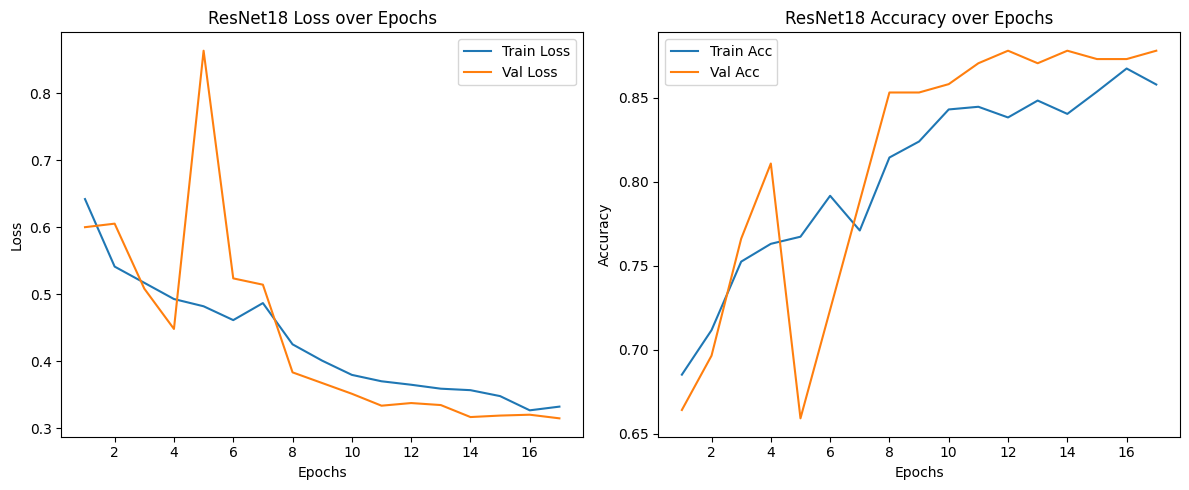

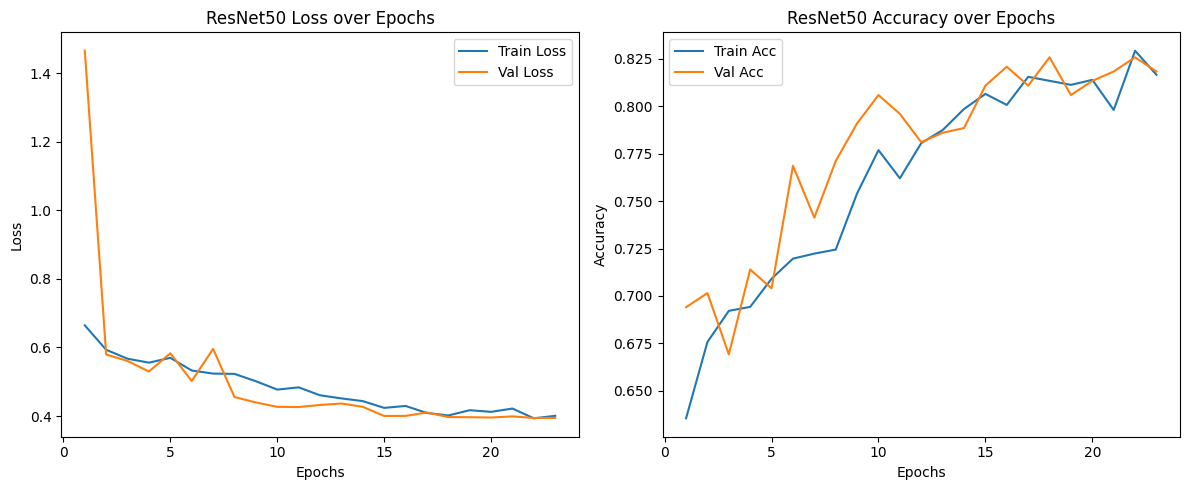

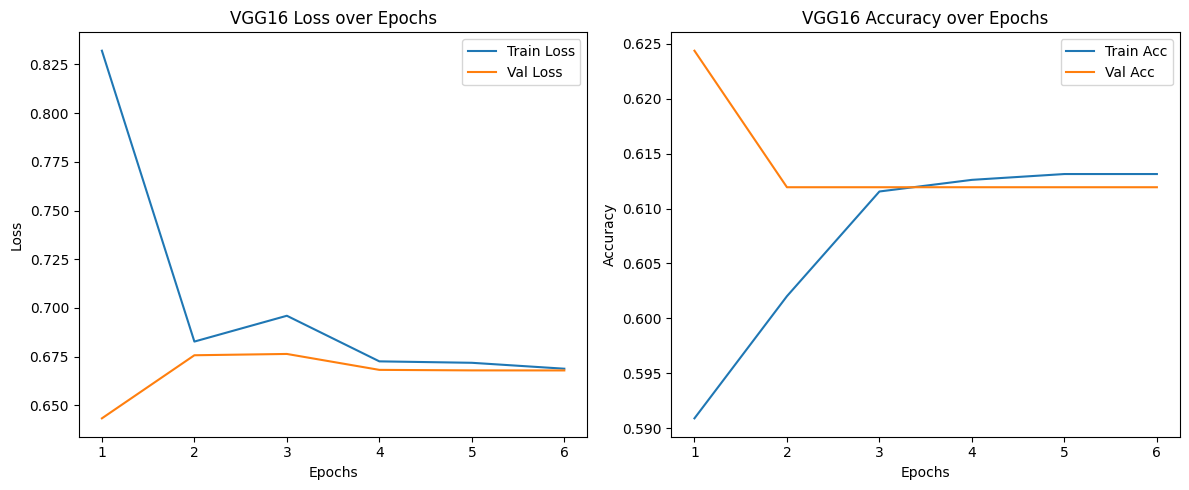

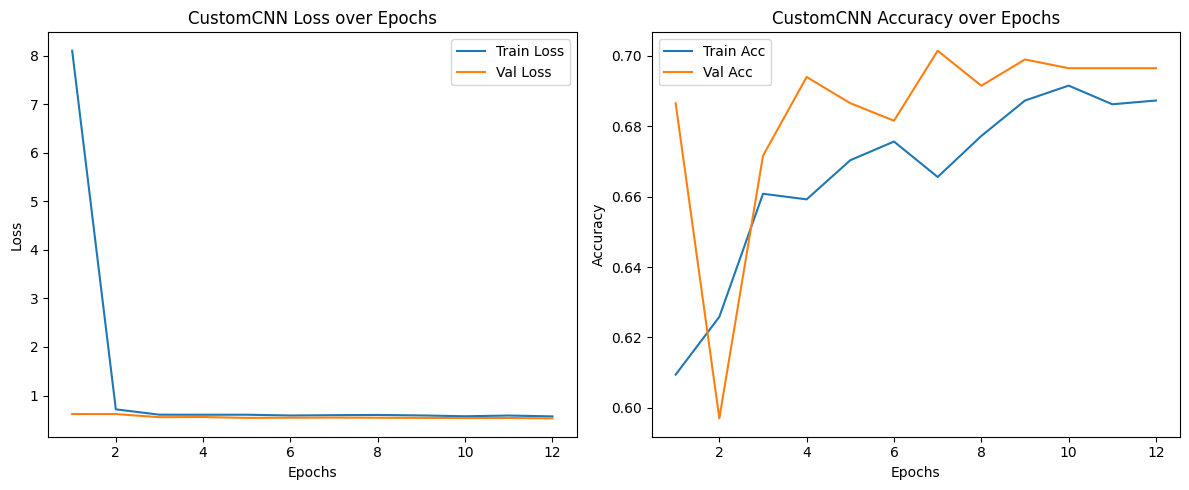

Step 9 executed: Training histories plotted


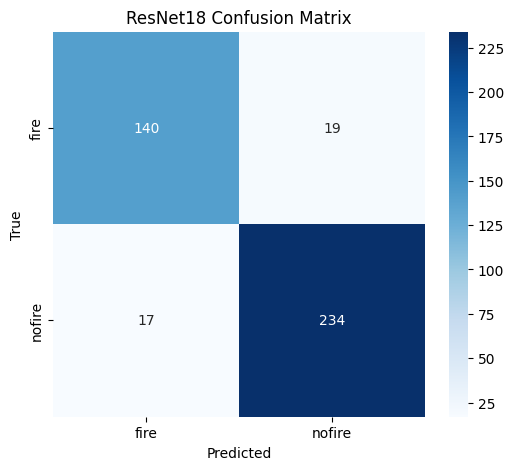

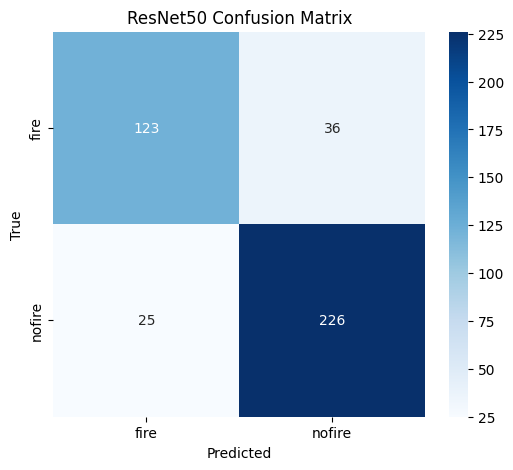

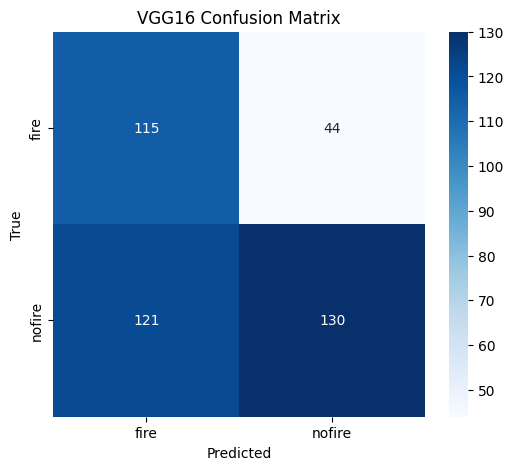

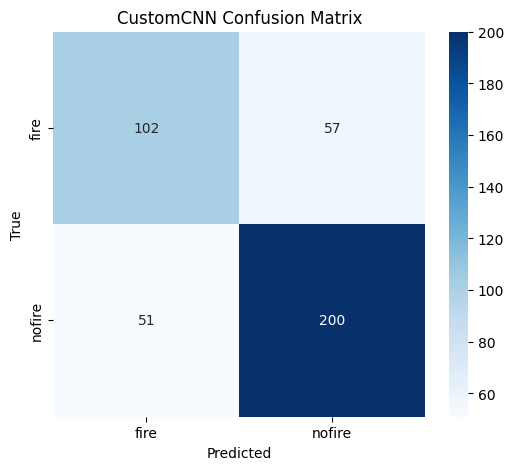

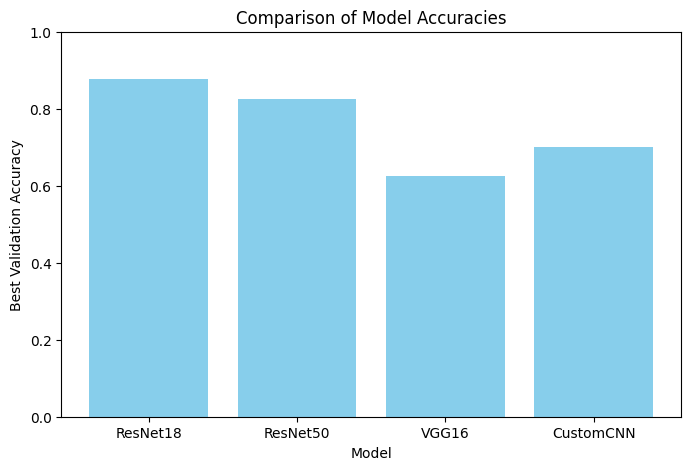

Step 9 executed: Test evaluation and comparison done


In [11]:
# Step 9: Plot Training Histories
def plot_history(history, title_prefix=""):
    epochs_range = range(1, len(history["train_losses"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history["train_losses"], label="Train Loss")
    plt.plot(epochs_range, history["val_losses"], label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} Loss over Epochs")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(epochs_range, history["train_accuracies"], label="Train Acc")
    plt.plot(epochs_range, history["val_accuracies"], label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} Accuracy over Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_history(history_r18, "ResNet18")
plot_history(history_r50, "ResNet50")
plot_history(history_vgg, "VGG16")
plot_history(history_custom, "CustomCNN")
print("Step 9 executed: Training histories plotted")

# Evaluate on Test Set
def evaluate_model_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

true_labels_r18, preds_r18 = evaluate_model_on_test(model_resnet18, test_loader_custom)
true_labels_r50, preds_r50 = evaluate_model_on_test(model_resnet50, test_loader_custom)
true_labels_vgg, preds_vgg = evaluate_model_on_test(model_vgg16, test_loader_custom)
true_labels_custom, preds_custom = evaluate_model_on_test(model_custom, test_loader_custom)

def plot_confusion_matrix(true_labels, preds, classes, title="Confusion Matrix"):
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

plot_confusion_matrix(true_labels_r18, preds_r18, train_dataset_custom.classes, title="ResNet18 Confusion Matrix")
plot_confusion_matrix(true_labels_r50, preds_r50, train_dataset_custom.classes, title="ResNet50 Confusion Matrix")
plot_confusion_matrix(true_labels_vgg, preds_vgg, train_dataset_custom.classes, title="VGG16 Confusion Matrix")
plot_confusion_matrix(true_labels_custom, preds_custom, train_dataset_custom.classes, title="CustomCNN Confusion Matrix")

best_r18 = max(history_r18["val_accuracies"])
best_r50 = max(history_r50["val_accuracies"])
best_vgg = max(history_vgg["val_accuracies"])
best_custom = max(history_custom["val_accuracies"])
model_accuracies = {"ResNet18": best_r18, "ResNet50": best_r50, "VGG16": best_vgg, "CustomCNN": best_custom}

plt.figure(figsize=(8,5))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel("Model")
plt.ylabel("Best Validation Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0,1)
plt.show()
print("Step 9 executed: Test evaluation and comparison done")
